# Проект: Поиск изображений по текстовому описанию

Мы работаем в фотохостинге для профессиональных фотографов «Со Смыслом» (With Sense). Пользователи размещают фотографии и сопровождают их текстовыми описаниями. Наша задача — разработать демонстрационную версию (PoC) сервиса поиска референсных фотографий по текстовому запросу.
Модель принимает на вход векторное представление изображения и текста, а на выходе выдаёт число от 0 до 1 — степень соответствия текста и картинки.

# Контекст

## Подробное описание задачи

Фотохостинг «Со Смыслом» предоставляет профессиональным фотографам площадку для размещения работ с подробными описаниями: место съёмки, модель камеры, сюжет и т.д. Описания к фотографиям могут оставлять как авторы, так и другие пользователи портала. Отдел разработки запускает эксперимент по созданию поиска референсных фотографий: пользователь вводит текстовое описание нужной сцены, а сервис возвращает наиболее подходящие изображения. Для получения одобрения руководства необходимо подготовить PoC (Proof of Concept) — рабочий прототип, демонстрирующий практическую осуществимость проекта. В ряде стран присутствия компании действуют юридические ограничения: запрещено предоставлять контент с изображением или описанием детей младше 16 лет без согласия родителей. На этапе PoC такой контент должен быть полностью исключён из обучающей выборки, а при тестовых запросах — заменён дисклеймером

## Подробное описание данных

* train_dataset.csv — обучающий датасет: имя файла изображения, идентификатор описания (формат <имя_файла>#<номер>), текст описания. На одно изображение приходится до 5 описаний.
* train_images/ — папка с изображениями для обучения.
* CrowdAnnotations.tsv — краудсорсинговые оценки соответствия пар изображение–текст: доля подтвердивших соответствие, количество подтвердивших и количество отклонивших.
* ExpertAnnotations.tsv — экспертные оценки (3 эксперта, шкала от 1 до 4): 1 — полное несоответствие, 2 — частичное совпадение элементов, 3 — соответствие с точностью до деталей, 4 — полное соответствие.
* test_queries.csv — тестовые запросы: идентификатор запроса, текст запроса, релевантное изображение.
* test_images/ — папка с изображениями для тестирования.

## Задачи и план выполнения проекта

**Задачи**: агрегировать экспертные и краудсорсинговые оценки в единую целевую переменную (от 0 до 1), очистить данные от юридически ограниченного контента, получить векторные представления изображений и текстов, обучить модель предсказания степени соответствия пары изображение–текст, выбрать лучшую модель и продемонстрировать работу поиска на тестовых данных.

**План**:

1. Загрузка данных и исследовательский анализ (EDA).
2. Фильтрация данных по юридическим ограничениям.
3. Векторизация изображений (ResNet50) и текстов (TF-IDF, BERT).
4. Объединение векторов и подготовка обучающей выборки.
5. Обучение моделей (линейная регрессия, полносвязная нейронная сеть), подбор гиперпараметров.
6. Тестирование лучшей модели и демонстрация работы поискового сервиса.
7. Общие выводы по проекту.

# Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

В файле с краудсорсинговыми оценками информация расположена в таком порядке: 

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке. 
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберем либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Наша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.

## Подготовка к выполнению

Установим дополнительные библиотеки Keras-NLP и Sentence-Transformers

In [43]:
%pip install -q --upgrade keras-nlp tensorflow
%pip install -q sentence-transformers
%pip install -q --upgrade torch torchvision
%pip install -q --upgrade typing_extensions
%pip install -q catboost


[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


Осуществим импорт библиотек

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pickle
from IPython.display import display, Markdown

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from PIL import Image

from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Input, Activation)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras
import tensorflow as tf
import keras_nlp

from tqdm import notebook

from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler

import sentence_transformers
from sentence_transformers import SentenceTransformer, util
import glob

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jupyter/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Зададим глобальные переменные. Зафиксируем рандомайзеры

In [3]:
PATH = '/home/jupyter/project/to_upload'
SEED = 31416
BLOCK = ['teenage', 'baby', 'child', 'teenager', 'girl', 'boy', 'kid']

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Первичный просмотр данных

Открываем датафреймы из наших файлов

In [4]:
def read_df(path=PATH) -> pd.DataFrame:
    df_train = pd.read_csv(Path(path, 'train_dataset.csv'))
    df_crowd = pd.read_csv(Path(path, 'CrowdAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'share_pos', 'count_pos', 'count_neg'])
    df_expert = pd.read_csv(Path(path, 'ExpertAnnotations.tsv'), sep='\t',
                           names=['image', 'query_id', 'first', 'second', 'third'])
    df_queries = pd.read_csv(Path(path, 'test_queries.csv'), index_col=[0], sep='|')
    df_images = pd.read_csv(Path(path, 'test_images.csv'), sep='|')
    
    return df_train, df_crowd, df_expert, df_queries, df_images

df_train, df_crowd, df_expert, df_queries, df_images = read_df()

Посмотрим данные поверхностно

In [5]:
display(Markdown("df_train"))
display(df_train.head())

display(Markdown("df_crowd"))
display(df_crowd.head())

display(Markdown("df_expert"))
display(df_expert.head())

display(Markdown("df_queries"))
display(df_queries.head())

display(Markdown("df_images"))
display(df_images.head())

df_train

image  ...                                         query_text
0  1056338697_4f7d7ce270.jpg  ...  A young child is wearing blue goggles and sitt...
1  1262583859_653f1469a9.jpg  ...  A young child is wearing blue goggles and sitt...
2  2447284966_d6bbdb4b6e.jpg  ...  A young child is wearing blue goggles and sitt...
3  2549968784_39bfbe44f9.jpg  ...  A young child is wearing blue goggles and sitt...
4  2621415349_ef1a7e73be.jpg  ...  A young child is wearing blue goggles and sitt...

[5 rows x 3 columns]

df_crowd

image                     query_id  ...  count_pos  count_neg
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2  ...          3          0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2  ...          0          3
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2  ...          0          3
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2  ...          0          3
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2  ...          0          3

[5 rows x 5 columns]

df_expert

image                     query_id  first  second  third
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1      1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1      2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1      2
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2      2
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1      2

df_queries

query_id  ...                      image
0  1177994172_10d143cb8d.jpg#0  ...  1177994172_10d143cb8d.jpg
1  1177994172_10d143cb8d.jpg#1  ...  1177994172_10d143cb8d.jpg
2  1177994172_10d143cb8d.jpg#2  ...  1177994172_10d143cb8d.jpg
3  1177994172_10d143cb8d.jpg#3  ...  1177994172_10d143cb8d.jpg
4  1177994172_10d143cb8d.jpg#4  ...  1177994172_10d143cb8d.jpg

[5 rows x 3 columns]

df_images

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

Проверим количество уникальных изображений в обучающем и тестовом наборах

In [6]:
print('Количество уникальных фото на трейне:', len(df_train['image'].unique()))
print('Количество уникальных фото на тесте:', len(df_queries['image'].unique()))

Количество уникальных фото на трейне: 1000
Количество уникальных фото на тесте: 100


In [7]:
print('Количество уникальных запросов на тесте:', df_queries.drop_duplicates().shape[0])

Количество уникальных запросов на тесте: 500


Посмотрим на количество оценок в экспертном и краудсорс-наборах

In [8]:
print('Количество уникальных сочетаний фото-текст оцененных экспертами:', df_expert.drop_duplicates().shape[0])
print('Количество уникальных сочетаний фото-текст оцененных людьми:', df_crowd.drop_duplicates().shape[0])

Количество уникальных сочетаний фото-текст оцененных экспертами: 5822
Количество уникальных сочетаний фото-текст оцененных людьми: 47830


Проверим, все ли текстовые описания в тестовом наборе совпадают с картинками. В столбце `query_id` зашифрована информация о номере картинки к которой дано описание в столбце `query_text`

In [9]:
df_queries[df_queries['query_id'].str[:-2] != df_queries['image']].shape[0]

0

Проверим соответствие текстовых описаний друг другу в обучающем и тестовом наборах

In [10]:
print('Уникальных текстовых описаний в трейне:', len(set(df_train['query_text'])))
print('Уникальных текстовых описаний в тесте:', len(set(df_queries['query_text'])))
print('Уникальных текстовых описаний которые есть в обоих наборах:', len(set(df_train['query_text']) & set(df_queries['query_text'])))

Уникальных текстовых описаний в трейне: 977
Уникальных текстовых описаний в тесте: 500
Уникальных текстовых описаний которые есть в обоих наборах: 0


Также проверим не совпадают ли картинки в обучающем и тестовом наборах

In [11]:
print('Уникальных картинок в трейне:', len(set(df_train['image'])))
print('Уникальных картинок в тесте:', len(set(df_queries['image'])))
print('Уникальных картинок которые есть в обоих наборах:', len(set(df_train['image']) & set(df_queries['image'])))

Уникальных картинок в трейне: 1000
Уникальных картинок в тесте: 100
Уникальных картинок которые есть в обоих наборах: 0


Познакомимся с изображениями, входящими в датасеты

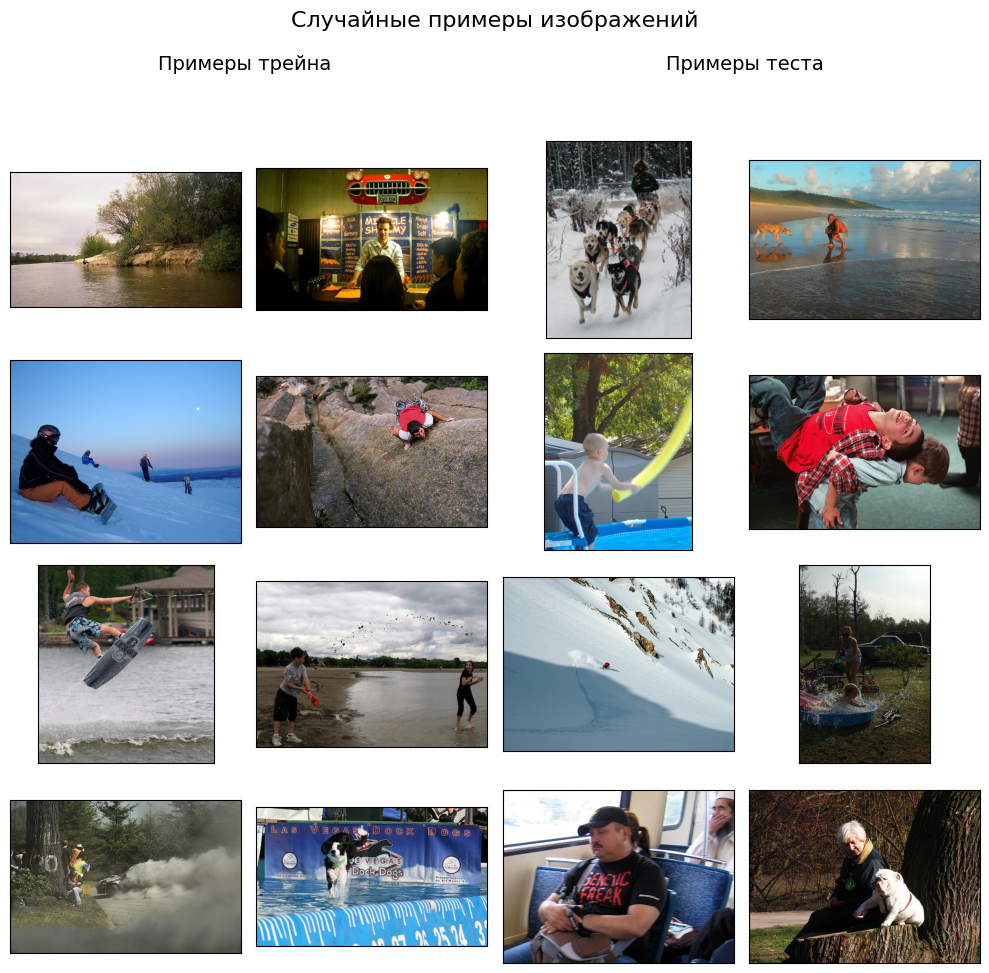

In [12]:
samples_train = list(df_train['image'].sample(8))
samples_test = list(df_queries['image'].sample(8))

fig = plt.figure(figsize=(10, 10))

fig.suptitle('Случайные примеры изображений', fontsize=16)
fig.text(0.25, 0.92, 'Примеры трейна', ha='center', fontsize=14)
fig.text(0.75, 0.92, 'Примеры теста', ha='center', fontsize=14)

for i in range(8):
    fig.add_subplot(4, 4, i + 1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

for i in range(8):
    fig.add_subplot(4, 4, i + 9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

## Выводы

Мы загрузили и ознакомились с данными.

Данный набор данных является частью датасета Flickr30k. В нашем распоряжении 1000 картинок на тест и 100 на трейн. Есть предобработанные файлы с сочетаниями описаний и картинок, для трейна и теста.

Для трейна при этом есть как экспертные оценки соответствия 5822 шт. так и оценки выполненные на краудфайдинговой платформе обычными людьми - 47830 шт, они частично совпадают.

Пересечений между наборами данных для трейна и теста не обнаружено.

На трейне использованы только описания картинок под номером #2, в тесте же к каждой картинке даны по 5 описаний.

Перейдём к аггрегации оценок для получения тестов.

# Подготовка данных

## Агрегация оценок

Аггрегируем экспертную оценку усреднением ответов и сведением к диапазону [0,1] по следующему принципу:

- Если все три оценки различны (то есть между экспертами нет совпадений), то берётся их среднее значение. Перед усреднением оценки сдвигаются на 1 (вычитается 3 из суммы), а затем результат нормируется делением на 3 и ещё раз на 3. Фактически это перевод исходной шкалы (предположительно 1–4) в диапазон [0, 1] через среднее значение.

- Если же есть совпадения (то есть хотя бы две оценки равны), то выбирается мода — наиболее часто встречающееся значение среди трёх экспертов. После этого оно сдвигается на 1 и делится на 3, то есть также переводится в нормализованную шкалу [0, 1].

In [13]:
def expert_aggregate(row) -> object:
    if row['first'] != row['second'] != row['third']:
        row['expert_score'] = (row['first'] + row['second'] + row['third'] - 3) / 3 / 3
    else:
        row['expert_score'] = (max(set([row['first'], row['second'], row['third']]), key = [row['first'], row['second'], row['third']].count) - 1) / 3
    return row

df_expert = df_expert.apply(expert_aggregate, axis=1)

Поскольку только 2329 пар картинка-текст имеют оценки и людей и экспертов мы объединим оба блока с оценками с флагом `outer`. Таким образом у части пар будут оценки экспертов (как более надёжные), для некоторых оценки людей, для остальных смешанная оценка. Далее мы объединим оценки

In [14]:
df_scores = pd.merge(df_expert, df_crowd, how='outer', on=['image', 'query_id'])

def score_aggregate(row) -> object:
    if np.isnan(row['expert_score']):
        row['score'] = row['share_pos']
    elif np.isnan(row['share_pos']):
        row['score'] = row['expert_score']
    else:
        row['score'] = row['expert_score'] * 0.6 + row['share_pos'] * 0.4
    return row

df_scores = df_scores.apply(score_aggregate, axis=1)

In [15]:
display(df_scores['score'].isna().value_counts())
df_scores['score'].describe()

False    51323
Name: score, dtype: int64

count    51323.000000
mean         0.075049
std          0.207266
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: score, dtype: float64

Добавим цели в наши датасеты

In [16]:
df_train = pd.merge(df_train, df_scores[['image', 'query_id', 'score']], how='outer', on=['image', 'query_id'])
to_fill = df_train[df_train['query_text'].notna()]

И заполним пропуски в описании после проставления оценок

In [17]:
def fill_text(row) -> object:
    if pd.isnull(row['query_text']):
        texts = to_fill[to_fill['query_id'] == row['query_id']]['query_text']
        if len(texts) > 0:
            row['query_text'] = texts.iloc[0]
    return row

df_train = df_train.apply(fill_text, axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       51323 non-null  object 
 1   query_id    51323 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.0+ MB


In [18]:
#Отбросим пропуски

df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       50214 non-null  object 
 1   query_id    50214 non-null  object 
 2   query_text  50214 non-null  object 
 3   score       50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


## Проверка данных

Для избавления от нелегального контента мы воспользуемся текстовыми описаниями файлов - объявим список слов для поиска нелегального контента, очистим, токенизируем и лемматизируем текст, чтобы было легче искать запросы связанные с детьми. Отметим в обучающем наборе фото подлежащие блокировке по следующему механизму:

1. Сначала функция get_lemmas выполняет нормализацию текста. Из строки удаляются все символы, кроме латинских букв, затем текст приводится к нижнему регистру. После этого выполняется токенизация (nltk.word_tokenize), и каждый токен лемматизируется через WordNetLemmatizer. В результате функция возвращает список лемм — то есть слов в их базовой форме.

2. Далее функция cleaning применяет эту предобработку к полю query_text. Полученный список лемм проверяется на наличие слов из списка BLOCK (предположительно, это словарь запрещённых или токсичных слов).

3. Если хотя бы одно слово из текста входит в BLOCK, в поле to_block записывается 1. Если совпадений нет — записывается 0.

In [19]:
lemmatize = nltk.WordNetLemmatizer()

def get_lemmas(text) -> list:
    text = re.sub('[^a-zA-Z]', ' ', text).lower()
    text = nltk.word_tokenize(text, language = 'english')
    text = [lemmatize.lemmatize(word) for word in text]

    return text

def cleaning(row) -> object:
    text = get_lemmas(row['query_text'])
    if [i for i in text if i in BLOCK]:
        row['to_block'] = 1
    else:
        row['to_block'] = 0

    return row

In [20]:
df_train = df_train.apply(cleaning, axis=1)

Посмотрим пример заблокированных единиц

In [21]:
print(df_train[df_train['to_block'] == 1]['query_text'].sample(10).unique())

['Three children in a black dog kennel .'
 'A woman and a naked child wade into the ocean .'
 'A little girl has dunked her head in a bowl of water .'
 "A picture of Albert Einstein on a white bear statue , with a little boy standing under the bear statue 's face ."
 'A young girl plays in fountain water .'
 'Three boys play around a fountain in an office building courtyard .'
 'Two girls walking down the street .'
 'A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue watches from behind .'
 "A young girl falls asleep in her father 's arms while seated on an airplane ."
 'A young girl in a white dress watches bubbles while a woman and girl toddler observe .']


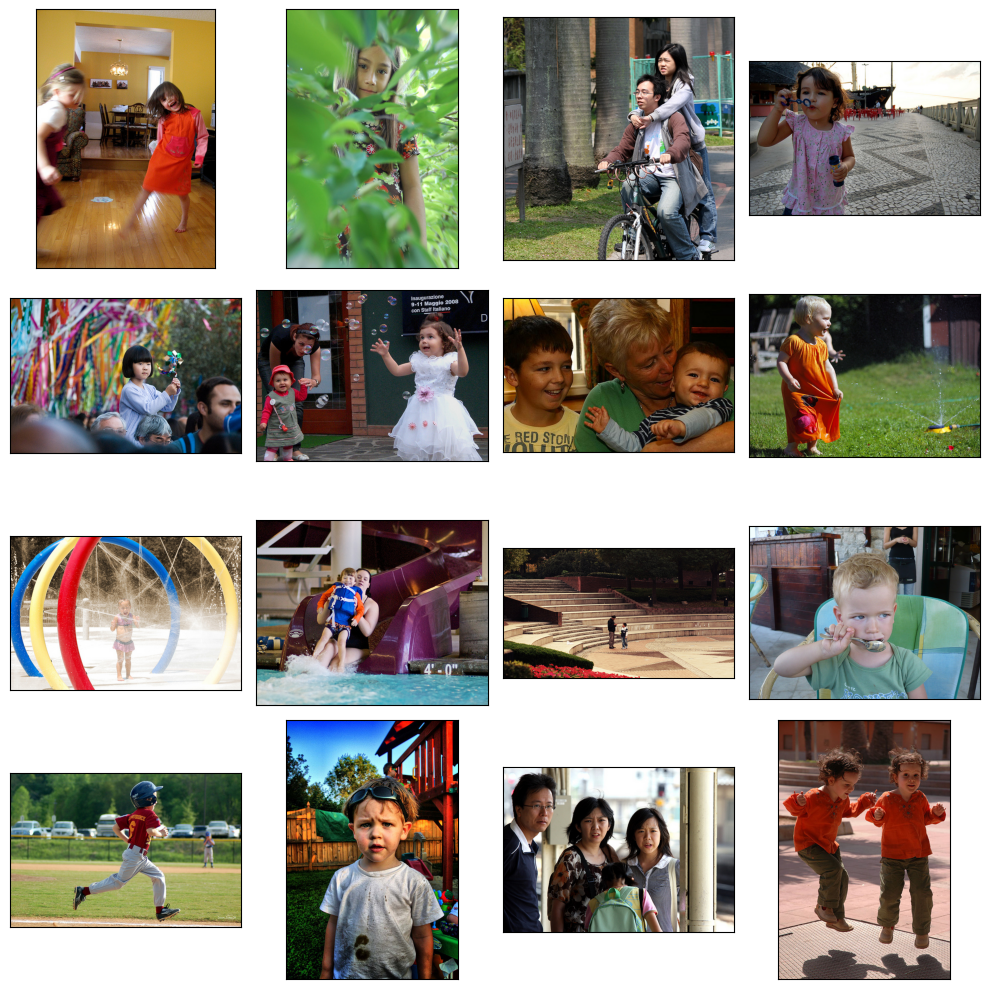

In [22]:
samples = list(df_train[df_train['to_block'] == 1]['query_id'].sample(16))
samples = [i[:-2] for i in samples]

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Похоже, что все верно. Значит мы можем удалить фотографии с детьми

In [23]:
df_train.drop(df_train[df_train['to_block'] == 1].index, inplace=True, errors='ignore')
df_train.drop(columns='to_block', inplace=True, errors='ignore')
df_train.reset_index(inplace=True, drop=True)

Посмотрим на итоговые объемы датасетов с допустимыми данными

In [24]:
display(Markdown("df_train"))
display(df_train.head(), df_train.info())

display(Markdown("df_queries"))
display(df_queries.head(), df_queries.info())

df_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36125 entries, 0 to 36124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       36125 non-null  object 
 1   query_id    36125 non-null  object 
 2   query_text  36125 non-null  object 
 3   score       36125 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


image  ...     score
0  1056338697_4f7d7ce270.jpg  ...  0.000000
1  3187395715_f2940c2b72.jpg  ...  0.333333
2   463978865_c87c6ca84c.jpg  ...  0.200000
3   488590040_35a3e96c89.jpg  ...  0.333333
4   534875358_6ea30d3091.jpg  ...  0.000000

[5 rows x 4 columns]

None

df_queries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  ...                      image
0  1177994172_10d143cb8d.jpg#0  ...  1177994172_10d143cb8d.jpg
1  1177994172_10d143cb8d.jpg#1  ...  1177994172_10d143cb8d.jpg
2  1177994172_10d143cb8d.jpg#2  ...  1177994172_10d143cb8d.jpg
3  1177994172_10d143cb8d.jpg#3  ...  1177994172_10d143cb8d.jpg
4  1177994172_10d143cb8d.jpg#4  ...  1177994172_10d143cb8d.jpg

[5 rows x 3 columns]

None

# Векторизация

## Изображений

В рамках этого пункта мы соберем дата-лоадер (генератор изображений) и сверточную нейросеть на основе ResNet50 для векторизации изображений

Found 36125 validated image filenames.


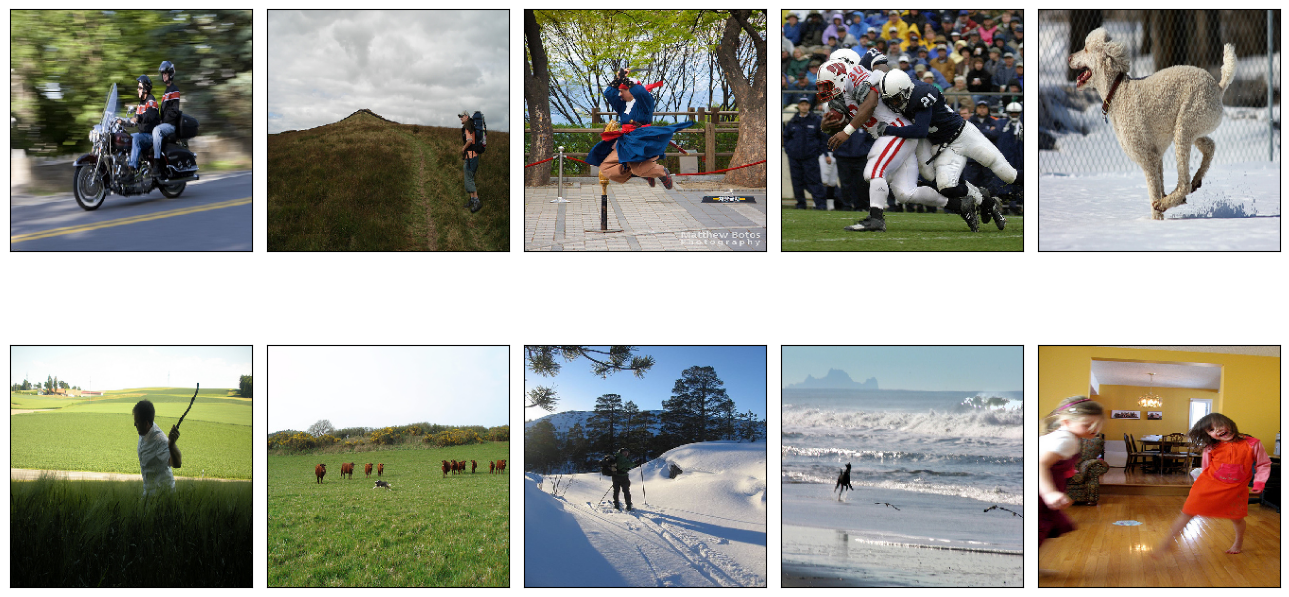

In [25]:
def load_train(path=PATH) -> ImageDataGenerator:
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        directory=Path(path, 'train_images'),
        x_col='image',
        y_col='score',
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

#ВРЕМЯ ТЕСТОВ!
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(13,10))
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

In [26]:
def create_model(input_shape=(256, 256, 3)):
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

def vectorize_pictures(model, train_data):
    predictions = model.predict(train_data)
    
    return predictions

In [27]:
pict_embeds = vectorize_pictures(create_model(), load_train())

I0000 00:00:1772131695.495105    8490 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:8c:00.0, compute capability: 7.0


Found 36125 validated image filenames.


2026-02-26 18:48:25.107462: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f7484003310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-26 18:48:25.107498: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla V100-PCIE-32GB, Compute Capability 7.0
2026-02-26 18:48:25.292491: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-26 18:48:26.259512: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2026-02-26 18:48:27.863673: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[16,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targ

2257/2258 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step

2026-02-26 18:56:13.742282: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[13,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-26 18:56:13.890892: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[13,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[13,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target

2258/2258 ━━━━━━━━━━━━━━━━━━━━ 473s 206ms/step


In [28]:
pict_embeds.shape

(36125, 2048)

Мы векторизовали картинки, теперь переходим к текстам

## Текстов

Для получения эмбеддингов текстов воспользуемся моделью BERT без head-классификатора, предварительно обработав тексты

In [29]:
#Модель
bert = keras_nlp.models.BertBackbone.from_preset('bert_base_en')

#Препроцессор
preprocessor = keras_nlp.models.BertPreprocessor.from_preset('bert_base_en')

Функция для векторизации текстов

In [30]:
def vectorize_text(model, data, preprocessor=preprocessor, batch_size=32, bar=True, verbose=0) -> np.array:
    embeddings = []
    tokenized = preprocessor(data)

    if bar:
        for i in notebook.tqdm(range(tokenized['token_ids'].shape[0] // batch_size + 1)):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    else:
        for i in range(tokenized['token_ids'].shape[0] // batch_size + 1):
        
            tokens = tokenized['token_ids'][batch_size*i:batch_size*(i+1)]
            token_types = tokenized['segment_ids'][batch_size*i:batch_size*(i+1)]
            mask = tokenized['padding_mask'][batch_size*i:batch_size*(i+1)]
            
            batch = {'token_ids' : tokens,
                    'segment_ids' : token_types, 
                    'padding_mask' : mask}
                    
            batch_embeddings = model.predict(batch, verbose=verbose)
            
            embeddings.append(batch_embeddings['pooled_output'])

    return np.concatenate(embeddings)

text = list(df_train['query_text'])

In [31]:
text_embeds = vectorize_text(model=bert, data=text)

  0%|          | 0/1129 [00:00<?, ?it/s]

In [32]:
text_embeds.shape

(36125, 768)

# Подготовка к предсказанию

## Объединение векторов

In [33]:
X = np.concatenate((pict_embeds, text_embeds), axis=1)
X.shape

(36125, 2816)

In [34]:
y = np.array(df_train['score'])
y.shape

(36125,)

## Скачивание векторов и таргета

Этот пункт у нас на случай повторных запусков дабы не считать эмбеддинги заново

In [35]:
with open('X.pickle', 'wb') as f:
    pickle.dump(X, f)

with open('y.pickle', 'wb') as f:
    pickle.dump(y, f)

# Модели предсказания соответствия

Сначала получим обучающую и тестовые выборки

In [37]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train['image']))

X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

Далее отмасштабируем значения

In [38]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Модели

В рамках проекта решается задача регрессии, поскольку целевая переменная отражает степень соответствия текста и изображения и представляет собой непрерывный скор. Модель должна предсказывать количественную оценку релевантности, а не бинарную принадлежность к классу, поэтому в качестве алгоритмов рассматриваются регрессионные модели.

Планируется сравнение трёх типов регрессоров, представляющих разные классы функциональных аппроксиматоров.

1. Линейная регрессия используется в качестве базовой модели. Она предполагает линейную зависимость между признаковым пространством (например, эмбеддингами текста и изображений) и целевой переменной. Модель обеспечивает интерпретируемый и устойчивый baseline, позволяющий оценить наличие линейной структуры в данных и служащий точкой отсчёта для более сложных алгоритмов.

2. CatBoostRegressor представляет собой градиентный бустинг на решающих деревьях и позволяет моделировать нелинейные зависимости и взаимодействия признаков. Он хорошо работает с табличными данными и плотными векторными представлениями, устойчив к масштабированию признаков и, как правило, демонстрирует высокое качество на задачах регрессии. Использование бустинга позволяет оценить выигрыш от более гибкой нелинейной модели по сравнению с линейным подходом.

3. MLP (многослойный перцептрон) рассматривается как универсальный нелинейный аппроксиматор. Нейронная сеть способна моделировать сложные взаимосвязи между признаками, что особенно актуально при работе с эмбеддингами, полученными из мультимодальных моделей. Включение MLP в сравнение позволяет проверить, обеспечивает ли нейросетевой подход дополнительный прирост качества по сравнению с ансамблевыми методами.

Таким образом, сравнение охватывает три уровня сложности: линейную модель, ансамблевый метод градиентного бустинга и нейросетевую архитектуру.

В качестве основной метрики качества целесообразно использовать RMSE (Root Mean Squared Error), поскольку она чувствительна к крупным отклонениям и сильнее штрафует большие ошибки предсказания. Это важно в задаче оценки релевантности, где существенные промахи по скору нежелательны.

Дополнительно рекомендуется рассчитывать MAE (Mean Absolute Error) для более устойчивой к выбросам оценки средней абсолютной ошибки. Для анализа способности модели сохранять относительное упорядочивание объектов может быть использован коэффициент корреляции (Пирсона или Спирмена), позволяющий оценить согласованность предсказанных и истинных значений с точки зрения ранжирования.

Комплексное использование RMSE, MAE и корреляции обеспечивает всестороннюю оценку как точности абсолютных значений, так и качества относительного соответствия

### Линейная регрессия

В данном эксперименте обучается модель линейной регрессии с использованием групповой кросс-валидации (GroupShuffleSplit). Разбиение по группам выполняется по идентификатору изображения, что предотвращает утечку информации между обучающей и валидационной выборками и обеспечивает корректную оценку качества при наличии нескольких текстов для одного изображения.

Оценка модели проводится по совокупности регрессионных и корреляционных метрик. В качестве основной метрики используется RMSE, отражающая среднеквадратичную ошибку предсказания и чувствительная к крупным отклонениям. Дополнительно рассчитывается MAE для устойчивой оценки средней абсолютной ошибки. Для анализа способности модели сохранять относительное упорядочивание объектов вычисляются коэффициенты корреляции Пирсона и Спирмена.

Итоговые значения метрик усредняются по фолдам кросс-валидации, что позволяет получить стабильную и репрезентативную оценку качества линейного baseline

In [49]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def pearson_corr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    if y_true.std() == 0 or y_pred.std() == 0:
        return 0.0
    return float(np.corrcoef(y_true, y_pred)[0, 1])

def spearman_corr(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    rt = y_true.argsort().argsort()
    rp = y_pred.argsort().argsort()
    if rt.std() == 0 or rp.std() == 0:
        return 0.0
    return float(np.corrcoef(rt, rp)[0, 1])

groups = df_train["image"].loc[train_indices].values

model = LinearRegression(n_jobs=-1)
cv = GroupShuffleSplit(n_splits=5, test_size=0.2, random_state=SEED)

scoring = {
    "rmse": make_scorer(rmse, greater_is_better=False),
    "mae": "neg_mean_absolute_error",
    "pearson": make_scorer(pearson_corr, greater_is_better=True),
    "spearman": make_scorer(spearman_corr, greater_is_better=True),
}

res = cross_validate(
    model,
    X_train,
    y_train,
    groups=groups,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
)

rmse_cv = (-res["test_rmse"]).mean()
mae_cv = (-res["test_mae"]).mean()
pearson_cv = res["test_pearson"].mean()
spearman_cv = res["test_spearman"].mean()

{
    "RMSE_CV": round(rmse_cv, 3),
    "MAE_CV": round(mae_cv, 3),
    "Pearson_CV": round(pearson_cv, 3),
    "Spearman_CV": round(spearman_cv, 3),
}

{'RMSE_CV': 0.224, 'MAE_CV': 0.141, 'Pearson_CV': 0.184, 'Spearman_CV': 0.131}

В качестве базовой модели обучена линейная регрессия на конкатенированных векторах изображений (ResNet50) и текстовых описаний (TF-IDF). Результаты кросс-валидации: RMSE = 0.224, MAE = 0.141, Pearson = 0.184, Spearman = 0.131.

Модель демонстрирует слабую предсказательную способность: линейная корреляция с целевой переменной составляет всего 0.18, а ранговая — 0.13. Это означает, что модель едва улавливает связь между признаками и степенью соответствия текста изображению, и практически не способна корректно ранжировать пары по релевантности.

### CatBoost

In [55]:
cat = CatBoostRegressor(
    loss_function="RMSE",
    random_seed=SEED,
    verbose=False
)

param_grid = {
    "depth": [4, 6],
    "learning_rate": [0.01, 0.1],
    "iterations": [300]
}

grid = GridSearchCV(
    estimator=cat,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose = 2
)

grid.fit(X_train, y_train, groups=groups)

best_model = grid.best_estimator_
best_rmse_cv = abs(grid.best_score_)

best_params = grid.best_params_

scoring_all = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "pearson": make_scorer(pearson_corr, greater_is_better=True),
    "spearman": make_scorer(spearman_corr, greater_is_better=True),
}

res = cross_validate(
    best_model,
    X_train,
    y_train,
    groups=groups,
    cv=cv,
    scoring=scoring_all,
    n_jobs=-1,
)

{
    "Best_params": best_params,
    "Best_RMSE_CV_grid": round(best_rmse_cv, 3),
    "RMSE_CV": round((-res["test_rmse"]).mean(), 3),
    "MAE_CV": round((-res["test_mae"]).mean(), 3),
    "Pearson_CV": round(res["test_pearson"].mean(), 3),
    "Spearman_CV": round(res["test_spearman"].mean(), 3),
}

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ........depth=4, iterations=300, learning_rate=0.01; total time= 3.2min
[CV] END ........depth=6, iterations=300, learning_rate=0.01; total time= 6.6min
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time= 3.2min
[CV] END .........depth=4, iterations=300, learning_rate=0.1; total time= 3.1min
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time= 5.1min
[CV] END ........depth=4, iterations=300, learning_rate=0.01; total time= 3.3min
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time= 6.4min
[CV] END .........depth=6, iterations=300, learning_rate=0.1; total time= 2.5min


{'Best_params': {'depth': 4, 'iterations': 300, 'learning_rate': 0.1},
 'Best_RMSE_CV_grid': 0.216,
 'RMSE_CV': 0.216,
 'MAE_CV': 0.136,
 'Pearson_CV': 0.222,
 'Spearman_CV': 0.152}

CatBoost показал умеренное улучшение относительно бейзлайна:

**RMSE 0.216 vs 0.224** — ошибка снизилась незначительно, на ~3.5%. Подбор гиперпараметров (depth=4, iterations=300, lr=0.1) помог, но прирост скромный.

**MAE 0.136 vs 0.141** — аналогично, небольшое улучшение. Средняя абсолютная ошибка по-прежнему около 14% от шкалы.

**Pearson 0.222 vs 0.184** — самый заметный прирост, +20% относительно бейзлайна. Нелинейная модель лучше улавливает связь между признаками и таргетом, но корреляция всё ещё слабая.

**Spearman 0.152 vs 0.131** — ранговая корреляция подросла, но остаётся низкой. Для задачи поиска (где ключевое — правильное ранжирование) этого недостаточно.

### MLP

Архитектура представляет собой полносвязную нейронную сеть (MLP) для задачи регрессии по векторным признакам. На вход подаётся фиксированный вектор признаков, далее сеть последовательно преобразует его через несколько нелинейных блоков, постепенно снижая размерность представления и выделяя информативные взаимодействия между признаками.

Сеть состоит из трёх скрытых блоков с убывающей шириной слоёв: 1024 → 256 → 64. Такая схема реализует принцип “бутылочного горлышка”: на первых уровнях модель имеет достаточную ёмкость, чтобы извлечь нелинейные зависимости из исходного пространства признаков, а затем размерность представления сжимается, что снижает риск переобучения и заставляет сеть формировать более компактные и обобщающие признаки.

Каждый скрытый блок включает последовательность Dense → BatchNormalization → ReLU → Dropout. Полносвязный слой (Dense) отвечает за обучение нелинейных преобразований признакового пространства. BatchNormalization стабилизирует распределения активаций, ускоряет сходимость и повышает устойчивость обучения при использовании Adam. Нелинейность ReLU позволяет моделировать сложные зависимости, недоступные линейным моделям. Dropout (0.3/0.3/0.2) выступает как регуляризатор, уменьшая коадаптацию нейронов и повышая обобщающую способность модели на новых данных.

Дополнительно во всех Dense-слоях используется L2-регуляризация (weight decay) с коэффициентом 1e-4. Это ограничивает рост весов, снижает вариативность модели и особенно полезно при обучении на эмбеддингах, где число признаков велико и переобучение может проявляться даже при относительно небольшой глубине сети. Комбинация L2 и Dropout обеспечивает более контролируемую ёмкость модели и улучшает стабильность качества на валидации.

Выходной слой имеет размерность 1 и активацию sigmoid. Это фиксирует диапазон предсказания в пределах [0, 1], что соответствует постановке задачи, где целевая переменная интерпретируется как нормализованный скор степени соответствия текста и изображения. Таким образом, модель не может выдавать некорректные значения вне допустимого диапазона, что упрощает интерпретацию результатов.

Оптимизация выполняется алгоритмом Adam с learning rate 3e-4 — это типичный стабильный стартовый шаг для MLP на плотных признаках: достаточно большой для быстрой сходимости и при этом не чрезмерный, чтобы не дестабилизировать обучение. В качестве функции потерь используется MSE, что соответствует регрессионной постановке и согласовано с основной метрикой RMSE. Дополнительно при обучении рассчитывается MAE, чтобы отслеживать среднюю абсолютную ошибку, менее чувствительную к редким крупным отклонениям

In [62]:
input_dim = X_train.shape[1]

NN = Sequential([
    Input(shape=(input_dim,)),

    Dense(1024, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),

    Dense(256, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.3),

    Dense(64, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation("relu"),
    Dropout(0.2),

    Dense(1, activation="sigmoid")
])

optimizer = Adam(learning_rate=3e-4)

NN.compile(
    optimizer=optimizer,
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse"),
             tf.keras.metrics.MeanAbsoluteError(name="mae")]
)

NN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1024)           │     2,884,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,168,897 (12.09 MB)

 Trainable params: 3,166,209 (12.08 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_rmse", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5, patience=2)
]

In [64]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=20,
    callbacks=callbacks,
    verbose=2, shuffle=True
    )

Epoch 1/20
786/786 - 15s - 19ms/step - loss: 0.2164 - mae: 0.1791 - rmse: 0.2543 - val_loss: 0.1750 - val_mae: 0.1316 - val_rmse: 0.2143 - learning_rate: 3.0000e-04
Epoch 2/20
786/786 - 4s - 5ms/step - loss: 0.1566 - mae: 0.1329 - rmse: 0.2252 - val_loss: 0.1298 - val_mae: 0.1273 - val_rmse: 0.2147 - learning_rate: 3.0000e-04
Epoch 3/20
786/786 - 4s - 5ms/step - loss: 0.1159 - mae: 0.1297 - rmse: 0.2237 - val_loss: 0.0967 - val_mae: 0.1230 - val_rmse: 0.2156 - learning_rate: 3.0000e-04
Epoch 4/20
786/786 - 4s - 5ms/step - loss: 0.0926 - mae: 0.1299 - rmse: 0.2217 - val_loss: 0.0832 - val_mae: 0.1254 - val_rmse: 0.2141 - learning_rate: 1.5000e-04
Epoch 5/20
786/786 - 4s - 5ms/step - loss: 0.0813 - mae: 0.1291 - rmse: 0.2208 - val_loss: 0.0747 - val_mae: 0.1243 - val_rmse: 0.2148 - learning_rate: 1.5000e-04
Epoch 6/20
786/786 - 4s - 5ms/step - loss: 0.0739 - mae: 0.1299 - rmse: 0.2202 - val_loss: 0.0688 - val_mae: 0.1247 - val_rmse: 0.2147 - learning_rate: 1.5000e-04
Epoch 7/20
786/786 -

MLP остановился по early stopping на эпохе 12. Смотрим на валидационные метрики:

**val_RMSE ~0.215** — практически на уровне CatBoost (0.216) и линейной регрессии (0.224). Нейросеть не дала заметного прорыва.

**val_MAE ~0.124** — лучший результат среди трёх моделей (LR: 0.141, CatBoost: 0.136). Средняя ошибка снизилась на ~12% относительно бейзлайна.

**Признаки переобучения:** train loss стабильно падает (0.216 → 0.058), а val_loss почти перестаёт улучшаться после 7-й эпохи (0.066 → 0.062). Разрыв train/val растёт — модель начала запоминать обучающую выборку. ReduceLR и early stopping сработали корректно, но разрыв заметен.

### Сопоставление и выводы

**Итого по трём моделям:**

| Модель | RMSE | MAE | Pearson | Spearman |
|---|---|---|---|---|
| Линейная регрессия | 0.224 | 0.141 | 0.184 | 0.131 |
| CatBoost | 0.216 | 0.136 | 0.222 | 0.152 |
| MLP | ~0.215 | ~0.124 | — | — |

Потолок качества определяется не качеством эмбеддингов, а самой задачей. Экспертные оценки субъективны и шумны (три эксперта нередко расходятся), и модель упирается именно в этот шум.
val_MAE = 0.124 на шкале [0, 1] — это вполне рабочий результат. Модель ошибается в среднем на ~12%, что для задачи соответствия текст-картинка приемлемо. Для поискового PoC важнее не точность предсказания абсолютного значения, а способность корректно ранжировать — то есть ставить более релевантные пары выше.

# Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для всех тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение. Сравним визуально качество поиска.

Создадим загрузчик тестовых изображений.

In [65]:
def load_test(path=PATH) -> ImageDataGenerator:
    train_datagen = ImageDataGenerator(rescale=1/255.)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=df_images,
        directory=Path(path, 'test_images'),
        x_col='image',
        y_col=None,
        target_size=(256, 256),
        batch_size=16,
        class_mode='input',
        seed=SEED)
    
    return train_gen_flow

In [66]:
pict_embeds_test = vectorize_pictures(create_model(), load_test())
pict_embeds_test.shape

Found 100 validated image filenames.
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

2026-02-26 20:37:36.299571: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[4,64,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,64,64,64]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-02-26 20:37:36.372412: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=1} for conv (f32[4,128,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[4,128,32,32]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 952ms/step


(100, 2048)

Напишем функцию, принимающую на вход текстовое описание и возвращающую 5 картиной с максимальной предсказанной оценкой схожести

In [67]:
def get_picture(text) -> None:
    if [i for i in get_lemmas(text) if i in BLOCK]:
        print('')
        print('-' * 20, text, '-' * 20)
        print('')
        print('This image is unavailable in your country in compliance with local laws.')
        print('')
        return None

    text_embed = vectorize_text(model=bert, data=[text], bar=False)

    X = np.concatenate(
        (
            pict_embeds_test,
            np.resize(text_embed, (pict_embeds_test.shape[0], 768))
        ),
        axis=1
    )
    X = scaler.transform(X)

    predictions = NN.predict(X, verbose=0)

    df = pd.concat(
        (df_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')),
        axis=1
    )

    df_sorted = df.sort_values(by='pred', ascending=False)
    top = list(df_sorted['image'].head(5))
    top_score = list(df_sorted['pred'].head(5))

    print('')
    print('-' * 20, text, '-' * 20)
    print('')

    fig = plt.figure(figsize=(15, 5))

    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['axes.linewidth'] = 0

    for i in range(5):
        ax = fig.add_subplot(1, 6, i + 1)
        image = Image.open(Path(PATH, 'test_images', top[i]))
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(
            0.5, -0.08,
            f"p={top_score[i]:.2f}",
            transform=ax.transAxes,
            ha="center",
            va="top"
        )

    if text in list(df_queries['query_text']):
        plt.rcParams['axes.edgecolor'] = 'green'
        plt.rcParams['axes.linewidth'] = 5

        ax = fig.add_subplot(1, 6, 6)
        orig_img = df_queries.loc[df_queries['query_text'] == text, 'image'].iloc[0]
        image = Image.open(Path(PATH, 'test_images', orig_img))
        ax.imshow(image)
        ax.set_xticks([])
        ax.set_yticks([])

        ax.text(
            0.5, -0.08,
            "original",
            transform=ax.transAxes,
            ha="center",
            va="top"
        )

    plt.tight_layout()
    plt.show()

    return None

Теперь выберем 10 случайных запросов из файла с тестовыми запросами и посмотрим на результаты

In [68]:
samples = df_queries.sample(10)
text_test = list(samples['query_text'])
text_test

['A girl sitting on the ground in the forest looking through binoculars .',
 'Children in costumes standing in line .',
 'Two black dogs are tugging at an orange toy that is between them .',
 'a boy runs through the grass .',
 'An adult male wearing a backpack walks and looks to the left .',
 'A man on a red bicycle rides past several pedestrians .',
 'A young boy poses for a picture in front of a playground .',
 'A group of dogs walk around outdoors .',
 "A little girl with her hands in the air is sitting on a man 's back while he is laying on a blanket .",
 'A dog jumping off a dock into a pool of water .']


-------------------- A girl sitting on the ground in the forest looking through binoculars . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- Children in costumes standing in line . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- Two black dogs are tugging at an orange toy that is between them . --------------------



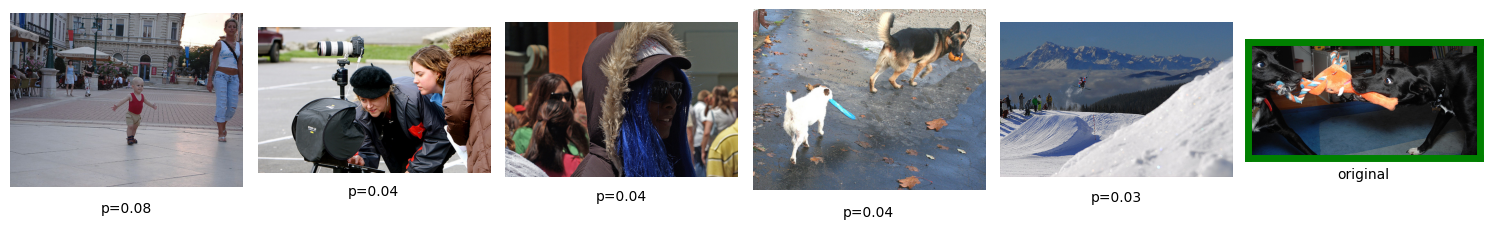


-------------------- a boy runs through the grass . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- An adult male wearing a backpack walks and looks to the left . --------------------



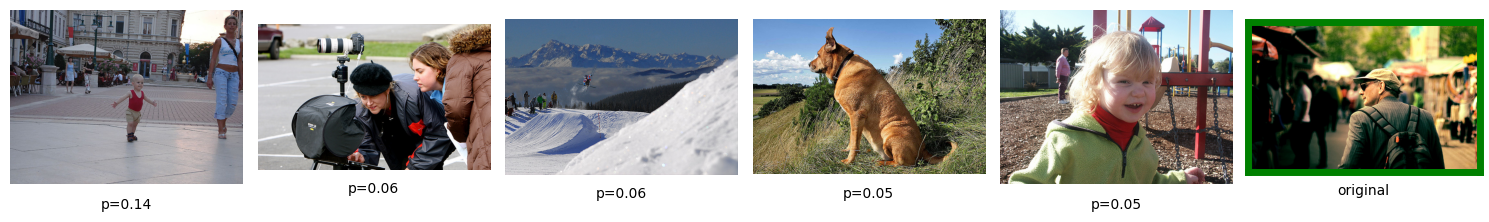


-------------------- A man on a red bicycle rides past several pedestrians . --------------------



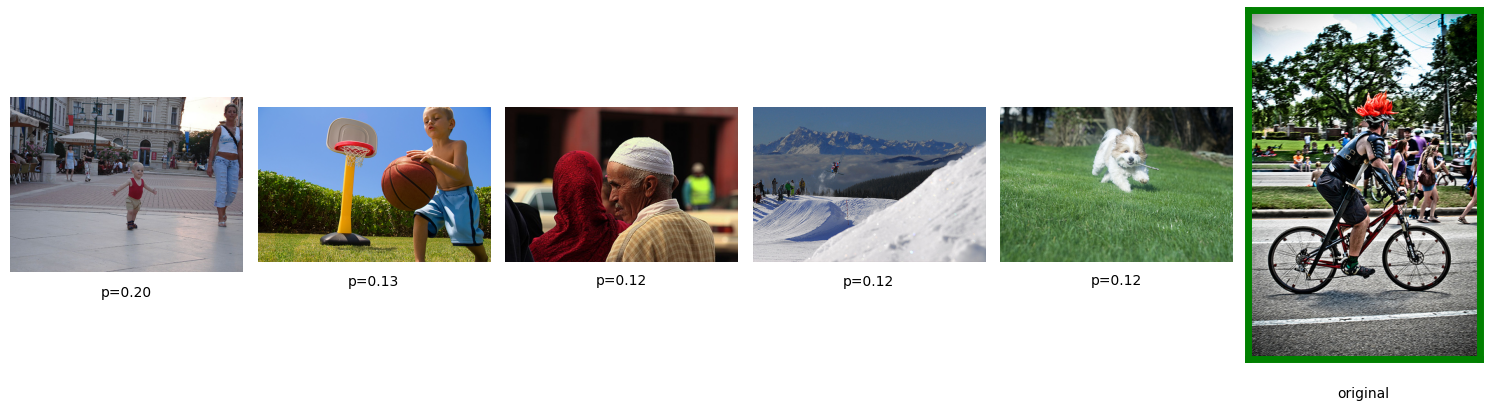


-------------------- A young boy poses for a picture in front of a playground . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A group of dogs walk around outdoors . --------------------



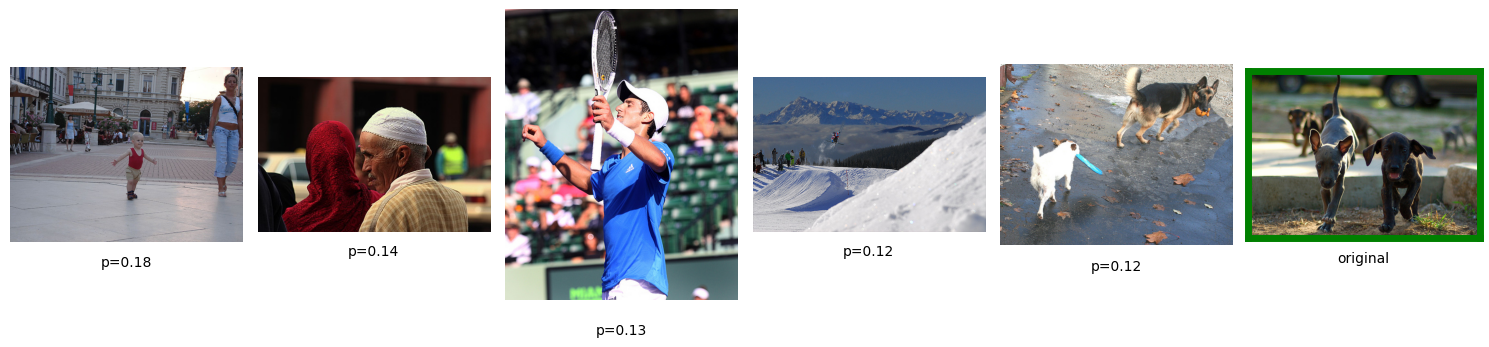


-------------------- A little girl with her hands in the air is sitting on a man 's back while he is laying on a blanket . --------------------

This image is unavailable in your country in compliance with local laws.


-------------------- A dog jumping off a dock into a pool of water . --------------------



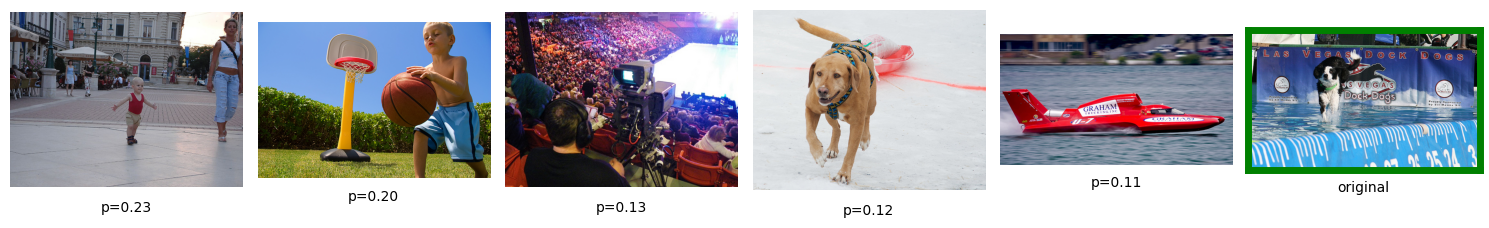

In [69]:
for text in text_test:
    get_picture(text)

# Выводы